In [1]:
import matplotlib.pyplot as plt
import numpy as np
import typhon as ty
from scipy.constants import g, R
from scipy.integrate import solve_ivp

In [2]:
### some constants
mr_water     = 0.01801528        # molecular mass of water
mr_dry       = 0.0289647         # molecular mass (per 1 mole) of dry air (M_r)                 
mr_ratio     = mr_water/mr_dry
rgas_dry     = R/mr_dry          # specific gas constant for dry air [J/Kg/K]      <-- used in ideal gas equation for hydrostsic rather than moist??
rgas_v       = R/mr_water        # specific gas constant for water
cp_dry       = 1004.9            # specific heat capacity (dry) air [J/Kg/K] (taken at 300K)   = 1.400*cv_dry 
cp_v         = 1864              # specific heat capacity of water vapour [J/Kg/K] (at 300K)l
latent_v     = 2437300           # specific latent heat of vapourisation of water [J/Kg]  (at 300K)
diffuse_v    = 2.42e-5           # water vapour diffusivity in dry air (at 300K) [m^2/s]
diffuse_heat = 2.2185e-5         # thermal diffusivity of heat in dry air (at 300K) [m^2/s]

### NOTE! temperature depedence of cp and latent_v ignored
### NOTE! Heat content of condensed water ignored

In [3]:
### some functions

def rgas_moist(qv):
    '''calculate moist specific gas
    constant of moist air:
    rgas_moist ~ (1+0.6qv)rgas_dry'''
    
    mfac = (1+qv*rgas_v/rgas_dry)/(1+qv)         # moist correction factor due to water vapour content of air
    
    return rgas_dry * mfac
    
    
def cp_moist(qv):
    '''calculate specific heat capacity of
    moist air: cp_moist ~ (1+0.9qv)cp_dry'''
    
    mfac = (1+qv*cp_v/cp_dry)/(1+qv)
    
    return cp_dry * mfac


def moist_rho(temp, p, qv):
   
    mfac =  (1+qv)/(1+qv/mr_ratio)
    
    return p/(rgas_dry*temp) * mfac


def moist_static_energy(z, temp, qv=0):
    ''' calculate the moist static energy
        (not assuming dry air cp) '''

    return  g*z + latent_v*qv + cp_moist(qv)*temp


def temp_pressure_profile(z, qv=0): 
    '''model temperature and pressure 
       profiles for atmosphere'''
    
    rgas = rgas_moist(qv)
    
    if z<=zbase:
        temp = tempg 
        p = pbase * np.exp(-g/(rgas*tempg) * (z-zbase))
    else:
        temp = tempg - lps_rate*(z-zbase)
        p = pbase * (1-lps_rate/tempg*(z-zbase))**(g/(rgas*lps_rate))

    return temp, p



In [4]:
###  Temp and P profile to raise parcel through (see Brdar and Seifert 2017 Fig 6.)
tempg        = 273.15            # temperature at ground level [K]
lps_rate     = 0.0062            # lapse rate above zbase [K/km]
pbase        = 100000            # pressure at cloud base [Pa]
zbase        = 0                 # height of cloud base [m]


### initial parcel conditions
w               = 2                                             # vertical wind speed [m/s]
z0              = 0                                             # initial z coordinate
temp0, p0       = temp_pressure_profile(z0, qv=0)                    # initial temp & pressure
relh0           = 80                                            # initial relative humidity (%)
qc0             = 0                                             # initial liquid water content

### droplet parameters
ndrops = 100                                  # no. drops per parcel (num_drops/vol_parcel)
r0 = 10
parcelvol = 1                                 # vol of parcel [m^3]               



### integration parameters
t_span     = [0,5000]
t_eval = np.linspace(t_span[0], t_span[1], 100)
max_step           = 0.1                                            # max tstep of ODE solver


### resulting values of some variables
psat0 = ty.physics.e_eq_water_mk(temp0) 
pv0 = relh0/100 * psat0                                 # initial water vapour pressure
qv0 = mr_ratio * pv0/(p0-pv0)                    # initial water mass mixing ratio (mass water/mass dry air)

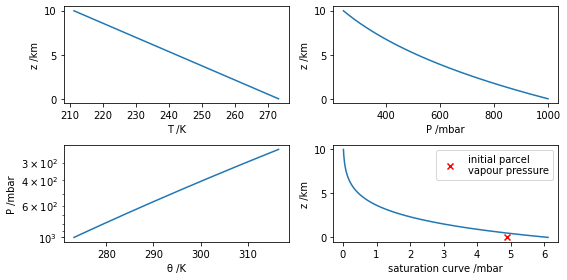

In [5]:
### plots of initial T, theta and pressure profiles
def surroundings(zrange):
    
    #assume surrounding air is dry (qv=0)
    
    l1, l2 = [], []
    for x in zrange:
        temp, p = temp_pressure_profile(x, qv=0)
        l1.append(temp)
        l2.append(p)
    temp = np.asarray(l1)
    p = np.asarray(l2)

    return temp, p

zrange = np.arange(0,w*t_span[-1],20)      # approx. z coordinates parcel will traverse
temp_surr, p_surr = surroundings(zrange)
theta_surr = temp_surr*(p_surr[0]/p_surr)**(rgas_dry/cp_dry)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,4))
axs = axs.flatten()

def axplt(ax,x,y,xlab=None,ylab=None, lab=None):
    ax.plot(x,y, label=lab)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

axplt(axs[0], temp_surr,zrange/1000, 'T /K', 'z /km')
axplt(axs[1], p_surr/100,zrange/1000,'P /mbar','z /km')
axplt(axs[2], theta_surr,p_surr/100,'\u03B8 /K','P /mbar')
axs[2].set_yscale('log')
axs[2].invert_yaxis()

###  initial saturation pressure profile
psat_surr = ty.physics.e_eq_water_mk(temp_surr)
axplt(axs[3], psat_surr/100, zrange/1000,'saturation curve /mbar', 'z /km')
axs[3].scatter(pv0/100, z0/1000, label='initial parcel \nvapour pressure', marker='x', color='r')
axs[3].legend(fontsize=10, loc='upper right')

fig.tight_layout()
#plt.close()

In [6]:
class Superdroplets():
    '''Class for all superdroplets, 
    eg. for object drops = Superdroplets(r0) where r0
    is array of drop radii, drops is object with
    radii and masses of all superdroplets'''
    
   
    def __init__(self, r, eps):
     
        # Common attributes of all superdroplets
        self.rho = 997                             # density of droplets (=density of water) [Kg/m^3]
        self.m_solute = 0
        
        # attributes unique to each object
        self.eps = eps                             # array of multiplicity of droplets
        self.r = r                                 # array of droplet radii
        
        self.m0 = self.rho*4/3*np.pi*(self.r)**3   # initial mass of droplet
 
    @property
    def m(self):
        return self.rho*4/3*np.pi*(self.r)**3    # droplet mass (assuming all water)
        
    @property
    def vol(self):
        return 4/3*np.pi*(self.r)**3             # droplet volume
    

ndrops = int(ndrops)
radii = np.full((ndrops), r0)                   # initial radii of all droplets in parcel
multi = np.ones(ndrops)                        # initial multiplicities (epsilons)
drops = Superdroplets(radii, multi)            # drops = object of all droplets in parcel

In [7]:
def dtemp_adiabat(z, temp, qv, dz, temp_surr, p_surr):
    ''' calculate dT/dt for adiabatic process
    of moist parcel (ignoring liquid water 
    content) via dT/dt = dz/dt * dT/dz = dz/dt * dT/dp * dp/dz.
    NOTE! assumes instanataneous volume change 
    of parcel to match pressure with that of 
    surrounding. Also assumes surroundings are dry and
    in hydrostatic equilibrium '''
    
    gamma = rgas_moist(qv)/cp_moist(qv)            # moist parcel constants
    dp_dz_p = -g/(rgas_dry*temp_surr)              # 1/p_surr * dp/dz       
    dtemp = dz*gamma*temp*dp_dz_p                  # dT/dt = dz * (p * dT/dp) * (1/p_surr * dp/dz)
   
    # (redundant but useful) pressure evolution
    # dp = w * dp_dz_p * p      
        
    return dtemp #,dp




def parcel_rising_cond_included(t, y, w):
    ''' differential equations for rising parcel 
    (thermo)dynamics with condensation onto droplets
    if supersaturation > 0.
    Parcel rises, expands adiabatically and then
    condenses water if qv > q_sat. Rate of condensation
    determined by growth rate of droplets (supersaturation
    is possible if growth slower than rise in relative
    humidity)'''

    z, temp, qv, qc = y[0:4] 
    radii = y[4:]
    #drops.r = radii
     
    ### dynamics of parcel
    #tau = 50*60                     # tau_w = 50min
    #dz = w*np.sin(2*np.pi*t/tau)
    dz = w


    ### thermodynamics of parcel
    temp_surr, p_surr = temp_pressure_profile(z)         # surrounding temp and pressure at height z (z[0] = z since z is a list)
    p = p_surr
    
    # adiabatic thermo changes
    dtemp = dtemp_adiabat(z, temp, qv, dz, temp_surr, p_surr)         
    

    # simple condensation via vapour diffusion onto droplets
    ### NOTE! no ventilation or curvature effects
    psat = ty.physics.e_eq_water_mk(temp)           # saturation pressure of parcel
    pv = qv*p/(mr_ratio + qv)                       # vapour pressure
    qsat = mr_ratio * psat/(p-pv)
    s = qv/qsat - 1
   
    if s > 0:                                       # if vapour is supersaturated
     
        gfactor = rgas_v*temp/(diffuse_v*psat) +\
            latent_v**2/(diffuse_heat*rgas_v*temp**2)
        dm = 4*np.pi*radii*s/gfactor               # mass change of each liquid water drop in drops parcel
        dr = dm/(997*4*np.pi*radii**2)

        dm_conds = np.sum(dm)#*drops.eps)              # total liquid water condensation rate per parcel
        dqv = -dm_conds/(parcelvol*moist_rho(temp, p, qv))
        dtemp_c = -latent_v/cp_moist(qv) * dqv
        dtemp+=dtemp_c
        dqc = -dqv
        
    else: #no condensation
        dr = np.zeros(len(radii))
        dqc = 0
        dqv = 0
    
    dy = [dz, dtemp, dqv, dqc]
    dy.extend(dr)

    return dy


y0                 = [z0, temp0, qv0, qc0]
y0.extend(drops.r)
args               = [w]
sol = solve_ivp(parcel_rising_cond_included, t_span, 
                    y0, method='RK45', max_step=max_step, 
                                   t_eval=t_eval, args=args) 
time = sol.t
z, temp, qv, qc = sol.y[0:4]
radii = sol.y[4:]

In [8]:
### surrounding temp and pressure profile at (z,t) of parcel ODEs solution
temp_surr, p_surr = surroundings(z)
theta_surr = temp_surr*(p_surr[0]/p_surr)**(rgas_dry/cp_dry)


### other parcel thermodynamic variables
p = p_surr
theta = temp * (p[0]/p)**(rgas_moist(qv)/cp_moist(qv))
pv = qv*p/(mr_ratio + qv) 
relh = pv/ty.physics.e_eq_water_mk(temp) 
mse = moist_static_energy(z, temp, qv)

dry_adia = temp0*(p/p0)**(rgas_moist(qv)/cp_moist(qv))
moist_lapse = ty.physics.moist_lapse_rate(p, temp, e_eq=None)
ind = np.where(relh==relh[relh>1][0])
#ind = 0
moist_adia = temp[ind] - moist_lapse*(z-z[ind])

temp2theta = (p[0]/p)**(rgas_moist(qv)/cp_moist(qv))
theta_dry_adia = dry_adia * temp2theta
theta_moist_adia = moist_adia * temp2theta


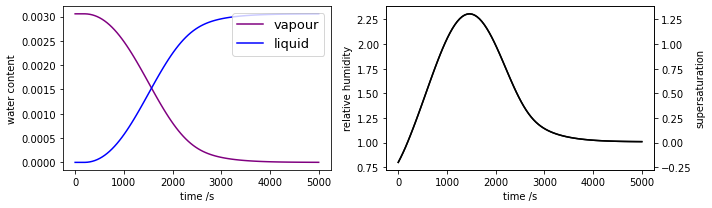

In [9]:
### plots of time evolution of water as parcel rises

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

axs2 = axs[1].twinx()

axs[0].plot(time, qv, color='purple', label='vapour')
axs[0].plot(time, qc, color='blue', label='liquid')
axs[1].plot(time, relh, color='k')
axs2.plot(time, relh-1, color='k')
axs[0].set_xlabel('time /s')
axs[0].set_ylabel('water content')
axs[1].set_xlabel('time /s')
axs[1].set_ylabel('relative humidity')
axs2.set_ylabel('supersaturation')
plt.tight_layout()
axs[0].legend(fontsize=13, loc='upper right')
plt.show()



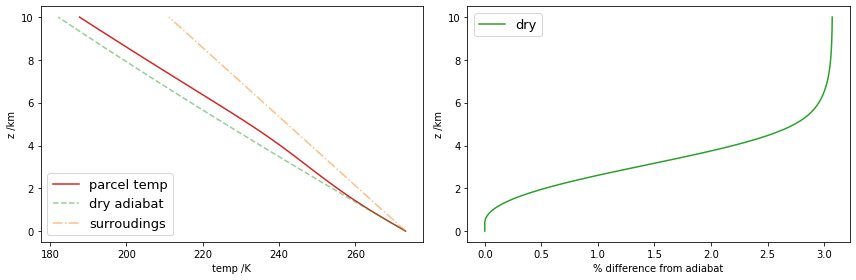

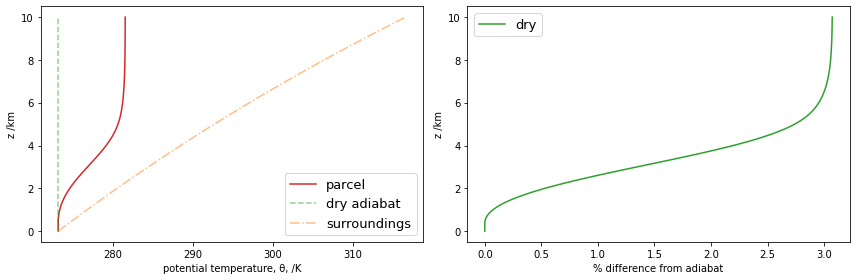

In [10]:
# spatial evolution of temperature, pressure and potential temp as parcel rises

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax1.plot(temp, z/1000, color='C3', label='parcel temp')
ax1.plot(dry_adia,z/1000, '--', color='C2', alpha=0.5, label='dry adiabat')
#ax1.plot(moist_adia,z/1000, '--', color='C0', alpha=0.5, label='moist adiabat')
ax1.plot(temp_surr,z/1000, linestyle='-.', color='C1',alpha=0.5, label='surroudings')
ax1.set_xlabel('temp /K')
ax1.set_ylabel('z /km')
ax1.legend(fontsize=13, loc='lower left')

ax2.plot((temp-dry_adia)/dry_adia*100, z/1000, color='C2', label='dry')
#ax2.plot((temp-moist_adia)/moist_adia*100, z/1000, color='C0', label='moist')
ax2.set_xlabel('% difference from adiabat')
ax2.set_ylabel('z /km')
ax2.legend(fontsize=13)
plt.tight_layout()
plt.show()



fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax1.plot(theta, z/1000, color='C3', label='parcel')
ax1.plot(theta_dry_adia, z/1000, '--', alpha=0.5, color='C2', label='dry adiabat')
#ax1.plot(theta_moist_adia, z/1000, '--', alpha=0.5, color='C0', label='moist adiabat')
ax1.plot(theta_surr, z/1000, linestyle='-.', alpha=0.5, color='C1', label='surroundings')
ax1.set_xlabel('potential temperature, \u03B8, /K')
ax1.set_ylabel('z /km')
ax1.legend(fontsize=13)

ax2.plot((theta-theta_dry_adia)/theta_dry_adia*100, z/1000, color='C2', label='dry')
#ax2.plot((theta-theta_moist_adia)/theta_moist_adia*100, z/1000, color='C0', label='moist')
ax2.set_xlabel('% difference from adiabat')
ax2.set_ylabel('z /km')
ax2.legend(fontsize=13)
plt.tight_layout()
plt.show()



fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax1.plot(p/100, z/1000, label='parcel', color='C4')
ax1.plot(p_surr/100, z/1000, linestyle='-.',alpha=0.5, color='C1', label='surroundings')
ax1.set_xlabel('pressure /mbar')
ax1.set_ylabel('z /km')
ax1.legend(fontsize=13)

ax2.plot((p-p_surr)/p_surr*100, z/1000, color='C1')
ax2.set_xlabel('% difference from surroundings')
ax2.set_ylabel('z /km')

plt.tight_layout()
plt.close()

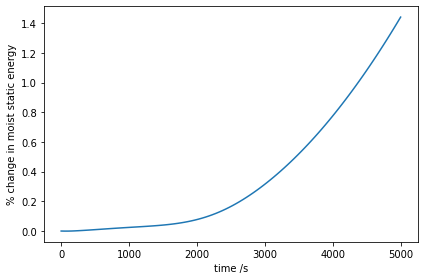

In [11]:
mse = moist_static_energy(z, temp, qv)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(time, ((mse-mse[0])/mse[0]*100))
ax.set_ylabel('% change in moist static energy')
ax.set_xlabel('time /s')

plt.tight_layout()
plt.show()

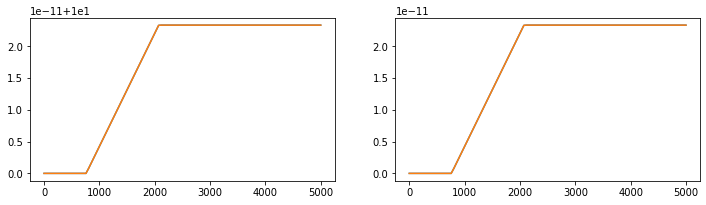

In [13]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

for r in radii[::50]:
    ax[0].plot(time,r)
    ax[1].plot(time, r-r[0])
